## 군집 평가 - 실루엣 분석
- 실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지 나타냄
- 실루엣 분석은 개별 데이터가 가지는 군집화 지표인 실루엣 계수를 기반으로 함
- 개별 데이터가 가지는 실루엣 계수는 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화되어 있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지를 나타내는 지표

### 실루엣 계수
- 실루엣 계수 : 개별 데이터가 가지는 군집화 지표
- -1 ~ 1사이의 값을 가지며, 1로 가까워질수록 근처의 군집과 더 멀리 떨어져 있다는 것이고 0에 가까울수록 근처의 군집과 가까워진다는 것
- 음수 값은 아예 다른 군집에 데이터 포인트가 할당됐음을 뜻함
- 1에 가까울수록 군집화가 잘 되었고, 음수는 해당 데이터의 군집화가 잘못 되었다는 뜻

### 실습 : 붓꽃 데이터에서 실루엣 계수 계산

In [5]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

# 실루엣 분석 metric 값을 구하기 위한 API cnrk
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

iris = load_iris()

feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
irisDF = pd.DataFrame(data = iris.data, columns = feature_names)

# kmeans 군집화 수행
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, random_state = 0).fit(irisDF)
# 데이터 당 클러스터 값 할당
irisDF['cluster'] = kmeans.labels_

print(irisDF.shape)
irisDF.head()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [7]:
# iris의 모든 개별 데이터에 실루엣 계수를 구함
score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples() return 값의 shape', score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
irisDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함
average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score : {0:.3f}'.format(average_score))

irisDF.head(15)

silhouette_samples() return 값의 shape (150,)
붓꽃 데이터셋 Silhouette Analysis Score : 0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315
3,4.6,3.1,1.5,0.2,1,0.805014
4,5.0,3.6,1.4,0.2,1,0.849302
5,5.4,3.9,1.7,0.4,1,0.748280
6,4.6,3.4,1.4,0.3,1,0.821651
7,5.0,3.4,1.5,0.2,1,0.853905
8,4.4,2.9,1.4,0.2,1,0.752150
9,4.9,3.1,1.5,0.1,1,0.825294


- 클러스터가 1인 데이터들은 0.8 정도의 실루엣 계수를 가지므로 군집화가 어느정도 잘 되었다고 볼 수 있음
- 하지만 실루엣 계수 평균값이 0.553인 이유는 다른 클러스터에 할당된 데이터들의 실루엣 계수값이 작아서임

In [8]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

<AxesSubplot:>

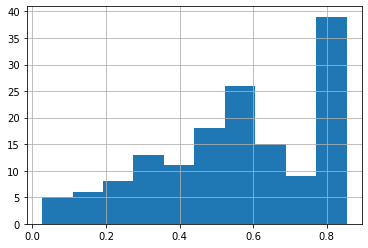

In [9]:
irisDF['silhouette_coeff'].hist()

### 실루엣 계수 시각화 통해 최적의 클러스터 수 찾기

In [12]:
### 여러 개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수 별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize = (4 * n_cols, 4), nrows = 1, ncols = n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 갯수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, max_iter = 500, random_state = 0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster :' + str(n_cluster) + '\n' \
                           'silhouette Score :' + str(round(sil_avg, 3)) )
        axs[ind].set_xlabel('The silhouette coefficient values')
        axs[ind].set_ylabel('Cluster label')
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([]) # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx() 형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                   facecolor = color, edgecolor = color, alpha = 0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x = sil_avg, color = 'red', linestyle = '--')

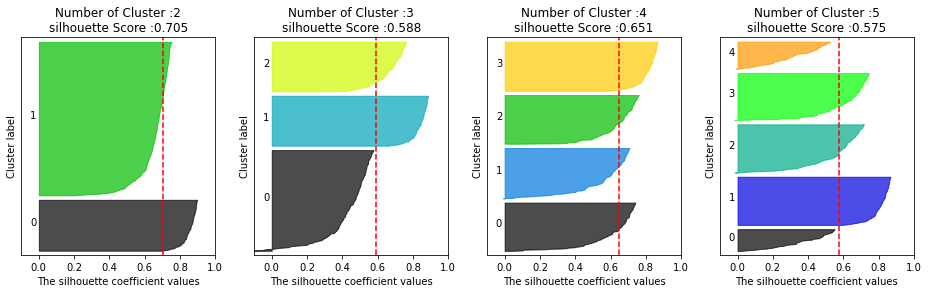

In [13]:
# make_blobs을 통해 clustering을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([2, 3, 4, 5], X)

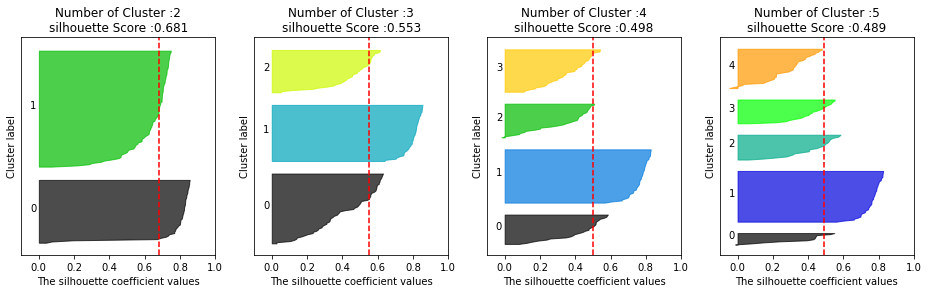

In [14]:
from sklearn.datasets import load_iris

iris = load_iris()
visualize_silhouette([2, 3, 4, 5], iris.data)